## Caricamento librerie e file

###Installazione Librerie

In [0]:
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 103kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-ffc80ukz
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-ffc80ukz
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=48f95d7ec3953b074c8d6bd0d040211221d0995467fe46df128ced3a682d546b
  Stored in directory: /tmp/pip-ephem-wheel-cache-di94pejh/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


### Caricamento librerie

In [0]:
import keras
from keras.preprocessing import image as kimage
from PIL import Image
import os
import numpy as np
from skimage.transform import resize
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
import joblib

from sklearn.neighbors import KDTree
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

Using TensorFlow backend.


### Caricamento file da drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -qq "/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/thumbnails_features_deduped_publish.zip"

### Creazione funzioni utili

In [0]:
# Funzione crop immagine
def crop(img, x, y, w, h):
    return img[y:y+h, x:x+w]

# Funzione ritaglio immagini
def ritaglio(img):
  '''
  Vengono selezionate solo le immagini
  in cui viene rilevato un unico volto
  '''
  try:
    faces, reject_level, level_weights = face_detector.detectMultiScale3(img, flags=1, scaleFactor=1.2, minNeighbors = 10 ,outputRejectLevels=True) 
    if len(faces)>1:
      img = []
    else:
      x,y,w,h = faces[0]
      y = y- int(h*0.1)
      h=int(h*1.2)
      img = crop(img, x, y, w, h)
  except:
    #print("problema rilevamento del volto")
    img = []
  finally:
    return img


def predict_image(img):
  '''
  preprocessing e predict delle immagini
  '''
  img = cv.resize(img, (224, 224))
  img = np.expand_dims(img, axis=0)
  img = np.array(img)*1.0
  img = preprocess_input(img, version=2)
  feature = model.predict(img)
  return(feature.flatten())

def load_data_crop(base_path = '/content/thumbnails_features_deduped_publish/'):
  # creazione liste
  paths = []
  features = []
  labels = []

  for f in tqdm(os.listdir(base_path)):
    for l in enumerate(sorted(os.listdir(base_path + f + '/'))):
      if l[1].endswith('.jpg'):
        path = base_path + f + '/' + str(l[1])
        # read immagine
        img = cv.imread(path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        # ritaglio volto immagine
        x = ritaglio(img)
        if x != [] and x.shape[0] != 0:
          # preprocesing ed estrazione feature
          feature = predict_image(x)
          # append alle liste
          features.append(feature)
          labels.append(f)
          paths.append(path)
  features = np.array(features)
  labels = np.array(labels)
  return features, paths, labels

def create_image(path):
  # caricamento immagine
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  # ritaglio
  x = ritaglio(img)
  plt.imshow(x)
  if (x != [] and x.shape[0]!= 0):
    feature = predict_image(x)
    return feature.reshape(1,-1)
  else:
    print('Volto non rilevato')

# Encoding del Dataset con Resnet50

##Caricamento modello

In [0]:
# caricamento resnet
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')














94699520/94694792 [==============================] - 2s 0us/step


## Caricamento immagini

In [0]:
face_detector = cv.CascadeClassifier('/content/drive/My Drive/Progetto DSIM/Video/haarcascade_frontalface_default.xml') 
# Caricamento dati
train_resnet_crop, paths_resnet_crop, labels_resnet_crop = load_data_crop()

In [0]:
print('len: ' + str(len(train_resnet_crop)))
print('shape: ' + str(train_resnet_crop[0].shape))

##Creazione KDTree

In [0]:
"""tree_resnet_crop_finale = KDTree(train_resnet_crop)"""

# Caricamento albero di ricerca e dati

tree_resnet_crop_finale = joblib.load('/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/face_resnet_crop_kdtree_resnet_finale.joblib')
train_resnet_crop = joblib.load('/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/train_resnet_crop.joblib')
paths_resnet_crop = joblib.load('/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/paths_resnet_crop.joblib')
labels_resnet_crop = joblib.load('/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/labels_resnet_crop.joblib')

# Salvataggio albero di ricerca e dati

"""import joblib
joblib.dump(tree_resnet_crop_finale, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/face_resnet_crop_kdtree_resnet_finale.joblib')
joblib.dump(train_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/train_resnet_crop.joblib')
joblib.dump(paths_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/paths_resnet_crop.joblib')
joblib.dump(labels_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/labels_resnet_crop.joblib')"""

"import joblib\njoblib.dump(tree_resnet_crop_finale, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/face_resnet_crop_kdtree_resnet_finale.joblib')\njoblib.dump(train_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/train_resnet_crop.joblib')\njoblib.dump(paths_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/paths_resnet_crop.joblib')\njoblib.dump(labels_resnet_crop, '/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/KDTree e Dataset/labels_resnet_crop.joblib')"

In [0]:
labels_resnet_crop[0]

'50 cent'

In [0]:
a = paths_resnet_crop[0].split("/")
a

['', 'content', 'thumbnails_features_deduped_publish', '50 cent', '0.jpg']

In [0]:
print(a[2] + "/" + a[3] + "/" + a[4])

thumbnails_features_deduped_publish/50 cent/0.jpg


## Query KDTree

####Dario

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(1, 2048)


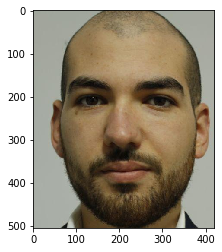

In [0]:
# query Dario
face_detector = cv.CascadeClassifier('/content/drive/My Drive/Progetto DSIM/Video/haarcascade_frontalface_default.xml') 
query_dario = create_image("/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/Prove Retrieval/dario3.jpg")
print(query_dario.shape)

In [0]:
dist_dario, ind_dario = tree_resnet_crop_finale.query(query_dario, k = 100)

In [0]:
# 10 volti più simili
for i in range(0, 10):
  plt.figure(figsize=(4, 4))
  plt.imshow(kimage.load_img(paths_resnet_crop[ind_dario[0, i]]))
  plt.title(label = str(labels_resnet_crop[ind_dario[0, i]]), fontdict = {"fontsize": 20})

####Paolo

(1, 2048)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


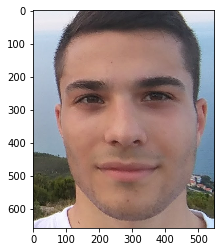

In [0]:
# query Paolo
face_detector = cv.CascadeClassifier('/content/drive/My Drive/Progetto DSIM/Video/haarcascade_frontalface_default.xml') 
query_paolo = create_image("/content/drive/My Drive/Progetto DSIM/Video/Image retrieval/Prove Retrieval/paolo4.jpg")
print(query_paolo.shape)

In [0]:
dist_paolo, ind_paolo = tree_resnet_crop_finale.query(query_paolo, k = 100)

In [0]:
# 10 volti più simili
for i in range(0, 10):
  plt.figure(figsize=(4, 4))
  plt.imshow(kimage.load_img(paths_resnet_crop[ind_paolo[0, i]]))
  plt.title(label = str(labels_resnet_crop[ind_paolo[0, i]]), fontdict = {"fontsize": 20})

## Real Time Queery

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


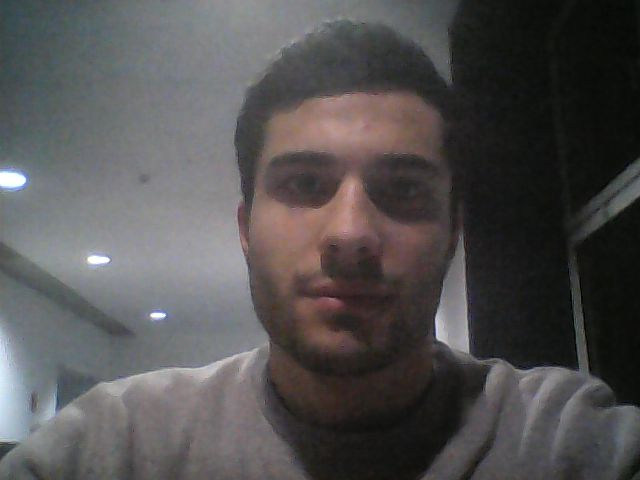

In [0]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

(1, 2048)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


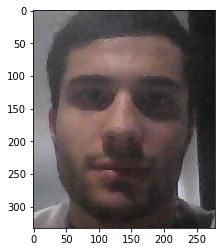

In [0]:
face_detector = cv.CascadeClassifier('/content/drive/My Drive/Progetto DSIM/Video/haarcascade_frontalface_default.xml') 

query = create_image("photo.jpg")
print(query.shape)

In [0]:
dist, ind = tree_resnet_crop_finale.query(query, k = 100)

In [0]:
# 10 volti più simili
for i in range(0, 10):
  plt.figure(figsize=(4, 4))
  plt.imshow(kimage.load_img(paths_resnet_crop[ind[0, i]]))
  plt.title(label = str(labels_resnet_crop[ind[0, i]]), fontdict = {"fontsize": 20})